# Data preparation

In [1]:
import numpy as np
import pandas as pd
from nltk.sentiment import SentimentIntensityAnalyzer
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# the library below is imported because of the warnings that popped up regarding to changes in the new versions
# of Pandas, which were irrelevant to this case, but looked kinda ugly 

import warnings
warnings.filterwarnings('ignore')

In [2]:
# function that cleans the data and assigns sentiment scores

sia = SentimentIntensityAnalyzer()

def data_prep(DF):
    
    df_tmp = DF.copy()
    df_tmp.drop_duplicates(subset=['tweet_id'], inplace=True)
    df_tmp.rename(columns={'created_at': 'date', 'tweet': 'text'}, inplace = True)
    df_tmp['date'] = df_tmp['date'].str[0:10]
    df_tmp['date'] = pd.to_datetime(df_tmp['date'], format='%Y-%m-%d', errors='coerce')
    df_tmp['scores'] = df_tmp['text'].apply(lambda t: sia.polarity_scores(t)['compound'])
    df_tmp['sentiment_type']=''
    df_tmp.loc[df_tmp.scores>=0.05,'sentiment_type']='POSITIVE'
    df_tmp.loc[(df_tmp.scores < 0.05) & (df_tmp.scores > -0.05),'sentiment_type']='NEUTRAL'
    df_tmp.loc[df_tmp.scores<=-0.05,'sentiment_type']='NEGATIVE'
    
    return df_tmp

In [3]:
%%time

# importing data

dtypes = {'author_id': 'str', 'date': 'str', 'tweet_id': 'str', 'retweet_count': 'str', 'reply_count': 'str', 
         'like_count': 'str', 'source': 'str', 'text': 'str', 'place_id': 'str', 'referenced_tweets': 'str',
         'scores': 'float', 'sentiment_type': 'str'}

df_raw = pd.read_csv('data/tweets_#COVID19.csv', dtype=dtypes)

CPU times: user 11.6 s, sys: 2.22 s, total: 13.8 s
Wall time: 14.8 s


In [4]:
df_raw.head()

,author_id,created_at,tweet_id,retweet_count,reply_count,like_count,source,text,place_id,referenced_tweets
0,author_id,created_at,tweet_id,retweet_count,reply_count,like_count,source,text,place_id,referenced_tweets
1,author_id,created_at,tweet_id,retweet_count,reply_count,like_count,source,text,place_id,referenced_tweets
2,894348543296712704,2020-02-11T23:59:44.000Z,1227381735509385218,2,1,2,Twitter for Android,"Hey @WHO, please give us more data. Tell us ab...",,
3,860163661,2020-02-11T23:57:44.000Z,1227381234428342273,0,0,3,Twitter for Android,most times our troubles keeps us awake.. and w...,,
4,28895141,2020-02-11T23:55:58.000Z,1227380791132508160,0,0,0,Twitter for iPhone,I think #coronavirus is fake. I don’t think it...,,


In [5]:
# dropping first two rows

df_raw.drop([0, 1], inplace=True)

In [6]:
df_raw

,author_id,created_at,tweet_id,retweet_count,reply_count,like_count,source,text,place_id,referenced_tweets
2,894348543296712704,2020-02-11T23:59:44.000Z,1227381735509385218,2,1,2,Twitter for Android,"Hey @WHO, please give us more data. Tell us ab...",,
3,860163661,2020-02-11T23:57:44.000Z,1227381234428342273,0,0,3,Twitter for Android,most times our troubles keeps us awake.. and w...,,
4,28895141,2020-02-11T23:55:58.000Z,1227380791132508160,0,0,0,Twitter for iPhone,I think #coronavirus is fake. I don’t think it...,,
5,777359239643664384,2020-02-11T23:54:54.000Z,1227380521572810752,5,0,11,TweetDeck,URGENT: Quarantine officer of #Japan's health ...,,
6,1169793310241755137,2020-02-11T23:50:56.000Z,1227379522955337734,7,0,3,Twitter Web App,#NEW: Quarantine officer of #Japan's Health Mi...,,
...,...,...,...,...,...,...,...,...,...,...
3052639,19357082,2021-11-30T00:02:00.000Z,1465471134413963264,0,0,2,Twitter Web App,B.C. health officials have yet to announce any...,,
3052640,1208795284718915591,2021-11-30T00:01:20.000Z,1465470968940347400,67,13,205,Twitter Web App,1/You have no doubt heard much lately about th...,,
3052641,3219670842,2021-11-30T00:01:14.000Z,1465470944168669187,1,0,1,smcapplication,Growth in 7D US Confirmed Covid Cases by Count...,,
3052642,88012139,2021-11-30T00:00:55.000Z,1465470864489689088,0,0,0,Twitter Web App,Do you think there were be another major US lo...,,


In [7]:
%%time 

# preparing the data for further analysis

df = data_prep(df_raw)

CPU times: user 12min 47s, sys: 5.25 s, total: 12min 52s
Wall time: 12min 57s


In [8]:
# counting daily tweets


df_daily_tweets = pd.DataFrame(df['date'].value_counts())
df_daily_tweets = df_daily_tweets.rename(columns={'date': 'count'}).sort_index()

In [9]:
%%time

# creating seperate dataframes for tweets with positive, neutral and negative sentiments

df_covid = pd.read_csv('data/small_covid_data3.csv')
df_covid = df_covid.loc[df_covid['iso_code'] == 'USA']

s_covid = pd.Series(df_covid['new_cases'])
s_covid.index = df_covid['date']
s_covid.index = pd.to_datetime(s_covid.index)

df_covid['new_cases'].replace(0, np.nan, inplace=True)
df_covid['new_cases'].fillna(method='bfill', inplace=True)

df_pos = df.loc[df['sentiment_type'] == 'POSITIVE']
df_neu = df.loc[df['sentiment_type'] == 'NEUTRAL']
df_neg = df.loc[df['sentiment_type'] == 'NEGATIVE']

s_pos = df_pos['date'].value_counts().sort_index()
s_neu = df_neu['date'].value_counts().sort_index()
s_neg = df_neg['date'].value_counts().sort_index()


s_all = pd.Series(df_daily_tweets['count'])

df_test = pd.concat([df_daily_tweets[:dt.datetime(2021,11,30)], s_pos[:dt.datetime(2021,11,30)], s_neu[:dt.datetime(2021,11,30)],
                     s_neg[:dt.datetime(2021,11,30)], s_covid[dt.datetime(2020,2,11):dt.datetime(2021,11,30)]], axis=1)

df_test.columns = ['tweets_all', 'tweets_pos', 'tweets_neu', 'tweets_neg', 'cases']
df_test = df_test.fillna(method="bfill")

CPU times: user 2.03 s, sys: 1.05 s, total: 3.09 s
Wall time: 3.83 s


In [10]:
df_test_org = df_test.copy()

In [11]:
sns.set_style("ticks")

In [12]:
# performing Augmented Dickey-Fuller (ADF) and Kwiatkowski–Phillips–Schmidt–Shin (KPSS) 
# tests to check stationarity of the time series 

adf_list, kpss_list = [], []

for column in df_test:
    result1 = adfuller(df_test[column])
    result2 = kpss(df_test[column])

    adf_list.append(result1)
    kpss_list.append(result2)

In [13]:
# printing results of the ADF test, the time series is not stationary

for wynik in adf_list:
    print(f'Test value: {wynik[0]:.3f}, p-value: {wynik[1]:.5f}, 0.05 critical value: {wynik[4]["5%"]:.3f}')

Test value: -2.377, p-value: 0.14837, 0.05 critical value: -2.866
Test value: -2.330, p-value: 0.16233, 0.05 critical value: -2.866
Test value: -2.773, p-value: 0.06225, 0.05 critical value: -2.866
Test value: -2.603, p-value: 0.09245, 0.05 critical value: -2.866
Test value: -2.225, p-value: 0.19718, 0.05 critical value: -2.866


In [14]:
# printing results of the KPSS test, the time series is not stationary

for wynik in kpss_list:
    print(f'Test value: {wynik[0]:.3f}, p-value: {wynik[1]:.5f}, 0.05 critical value: {wynik[3]["5%"]:.3f}')

Test value: 1.852, p-value: 0.01000, 0.05 critical value: 0.463
Test value: 1.784, p-value: 0.01000, 0.05 critical value: 0.463
Test value: 1.652, p-value: 0.01000, 0.05 critical value: 0.463
Test value: 2.100, p-value: 0.01000, 0.05 critical value: 0.463
Test value: 0.727, p-value: 0.01113, 0.05 critical value: 0.463


In [15]:
# standarizing time series

for column in df_test:
    avg, std = df_test[column].mean(), df_test[column].std()
    df_test[column] = df_test[column] - avg / std
    df_test[column] = df_test[column].diff().dropna()

In [16]:
df_test.dropna(inplace=True)
df_test = df_test_org.copy()

In [17]:
df_test

,tweets_all,tweets_pos,tweets_neu,tweets_neg,cases
2020-02-11,176,57,46,73,1.0
2020-02-12,413,162,111,140,1.0
2020-02-13,595,234,179,182,1.0
2020-02-14,560,241,154,165,2.0
2020-02-15,505,178,141,186,2.0
...,...,...,...,...,...
2021-11-26,1616,739,461,416,51098.0
2021-11-27,1235,557,297,381,24556.0
2021-11-28,1202,419,479,304,40824.0
2021-11-29,1849,780,637,432,196973.0


In [18]:
# creating training and testing datasets

df_training = df_test.loc[df_test.index < dt.datetime(2021,11,20)]
df_testing = df_test.loc[df_test.index >= dt.datetime(2021,11,20)]

In [19]:
df_training.tail()

,tweets_all,tweets_pos,tweets_neu,tweets_neg,cases
2021-11-15,1389,497,669,223,138962.0
2021-11-16,1417,775,398,244,87626.0
2021-11-17,1255,621,358,276,111404.0
2021-11-18,1368,555,544,269,110096.0
2021-11-19,1520,623,606,291,125588.0


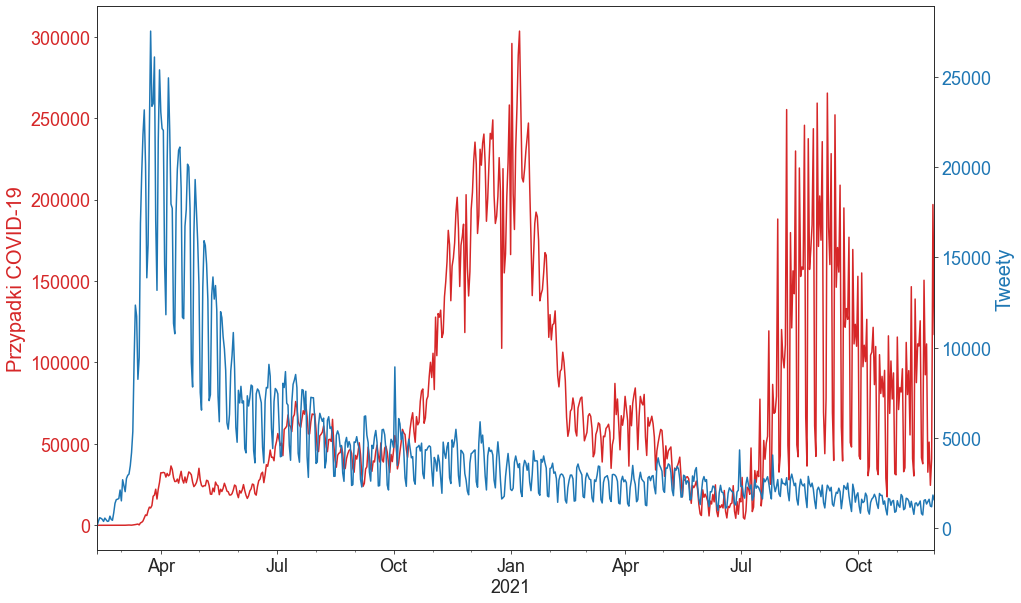

In [20]:
# plotting COVID-19 cases and Tweets 


fig, ax1 = plt.subplots(figsize=(15,10))
color = 'tab:red'
ax1.set_ylabel('Przypadki COVID-19', color=color, size=20)
ax1.tick_params(axis='y', labelcolor=color, labelsize=18)
ax1.tick_params(axis='x', labelsize=18)
df_test['cases'].plot(color=color)


ax2 = ax1.twinx() 
color = 'tab:blue'
ax2.set_ylabel('Tweety', color=color, size=20) 
ax2.tick_params(axis='y', labelcolor=color, labelsize=18)
df_test['tweets_all'].plot()

plt.savefig('oba.png', dpi=300)

In [21]:
# plotting partial autocorrelation function for all columns in the dataframe

for column in df_test:
    ax1 = plt.axes()
    plot_pacf(df_test[column], lags=40, method='ywm', ax=ax1, title='' )
    ax1.set_xlabel('p')
    ax1.set_ylabel('PACF')
    plt.savefig(f'{column}_pacf.png', dpi=300)
    plt.clf()

<Figure size 432x288 with 0 Axes>

In [22]:
# plotting autocorrelation function for all columns in the dataframe

for column in df_test:
    ax1 = plt.axes()
    plot_acf(df_test[column], lags=40, ax=ax1, title='' )
    ax1.set_xlabel('p')
    ax1.set_ylabel('ACF')
    plt.savefig(f'{column}_acf.png', dpi=300)
    plt.clf()

<Figure size 432x288 with 0 Axes>

In [23]:
# normalizing the data

avg_list, std_list, org_list = [], [], []

for column in df_training:
    avg, std = df_training[column].mean(), df_training[column].std()
    df_training[column] = (df_training[column] - avg) / std
    #df_training.loc[:, column] = df_training[column].apply(lambda x: (x - avg) / std)
    org = df_training[column][-1]
    df_training[column] = df_training[column].diff().dropna()
    #df_training.loc[:, [column]].diff().dropna()
    avg_list.append(avg)
    std_list.append(std)
    org_list.append(org)

In [24]:
df_training = df_training.dropna()

In [25]:
from matplotlib import rc

rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)

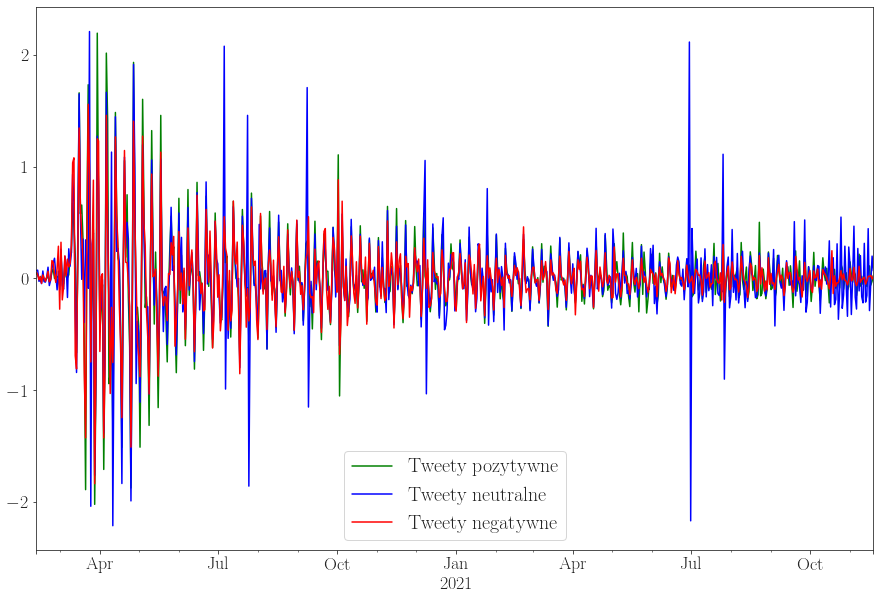

In [26]:
# plotting Tweets with the division into different sentiments after calculating first difference

fig = plt.figure(figsize=(15,10))
ax = plt.axes()
df_training['tweets_pos'].plot(label='Tweety pozytywne', color='g')
df_training['tweets_neu'].plot(label='Tweety neutralne', color='b')
df_training['tweets_neg'].plot(label='Tweety negatywne', color='r')
ax.tick_params(axis='both', labelsize=18)
plt.legend(fontsize=20)
plt.savefig('tweety_podzial_diff.png', dpi=300)

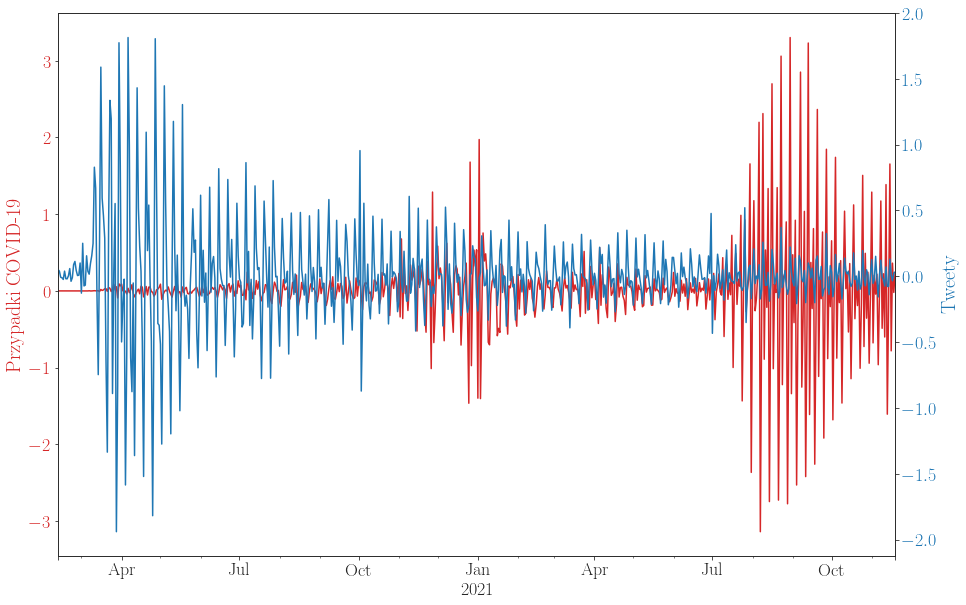

In [27]:
# plotting Tweets and cases of COVID after calculating first difference


fig, ax1 = plt.subplots(figsize=(15,10))
color = 'tab:red'
#ax1.set_xlabel('data')
ax1.set_ylabel('Przypadki COVID-19', color=color, size=20)
ax1.tick_params(axis='y', labelcolor=color, labelsize=18)
ax1.tick_params(axis='x', labelsize=18)
df_training['cases'].plot(color=color)


ax2 = ax1.twinx() 
color = 'tab:blue'
ax2.set_ylabel('Tweety', color=color, size=20) 
ax2.tick_params(axis='y', labelcolor=color, labelsize=18)
df_training['tweets_all'].plot()

plt.savefig('oba_DIFF.png', dpi=300)

In [28]:
# testing stationarity again


adf_list, kpss_list = [], []

for column in df_training:
    result1 = adfuller(df_training[column])
    result2 = kpss(df_training[column])

    adf_list.append(result1)
    kpss_list.append(result2)

In [29]:
for wynik in adf_list:
    print(f'Test value: {wynik[0]:.3f}, p-value: {wynik[1]:.5f}, 0.05 critical value: {wynik[4]["5%"]:.3f}')

Test value: -4.832, p-value: 0.00005, 0.05 critical value: -2.866
Test value: -4.925, p-value: 0.00003, 0.05 critical value: -2.866
Test value: -5.854, p-value: 0.00000, 0.05 critical value: -2.866
Test value: -4.116, p-value: 0.00091, 0.05 critical value: -2.866
Test value: -4.205, p-value: 0.00065, 0.05 critical value: -2.866


In [30]:
for wynik in kpss_list:
    print(f'Test value: {wynik[0]:.3f}, p-value: {wynik[1]:.5f}, 0.05 critical value: {wynik[3]["5%"]:.3f}')

Test value: 0.096, p-value: 0.10000, 0.05 critical value: 0.463
Test value: 0.085, p-value: 0.10000, 0.05 critical value: 0.463
Test value: 0.126, p-value: 0.10000, 0.05 critical value: 0.463
Test value: 0.093, p-value: 0.10000, 0.05 critical value: 0.463
Test value: 0.007, p-value: 0.10000, 0.05 critical value: 0.463


In [31]:
# plotting pacf and acf 

for column in df_training:
    ax1 = plt.axes()
    plot_pacf(df_training[column], lags=40, method='ywm', ax=ax1, title='' )
    ax1.set_xlabel('p')
    ax1.set_ylabel('PACF')
    plt.savefig(f'diff_{column}_pacf.png', dpi=300)
    plt.clf()

<Figure size 432x288 with 0 Axes>

In [32]:
for column in df_training:
    ax1 = plt.axes()
    plot_acf(df_training[column], lags=40, ax=ax1, title='' )
    ax1.set_xlabel('p')
    ax1.set_ylabel('ACF')
    plt.savefig(f'diff_{column}_acf.png', dpi=300)
    plt.clf()

<Figure size 432x288 with 0 Axes>

# VAR positive

Below I created a simple VAR model for Tweets with positive sentiment, which I later used to try to predict values of Tweets. The accuracy of the prediction is checked at the end of that segment.

In [33]:
training_pos = df_training[['tweets_pos', 'cases']]

In [34]:
training_pos.head()

,tweets_pos,cases
2020-02-12,0.041754,0.000000
2020-02-13,0.028631,0.000000
2020-02-14,0.002784,0.000015
2020-02-15,-0.025053,0.000000
2020-02-16,-0.004374,0.000000


In [35]:
model = VAR(training_pos, freq ='D')

In [36]:
# checking for best lags number 

for i in ['aic', 'bic', 'hqic']:
    results = model.fit(maxlags=40, ic=i)
    order = results.k_ar
    print(f"The suggested VAR order from {i} is {order}")

The suggested VAR order from aic is 22
The suggested VAR order from bic is 9
The suggested VAR order from hqic is 16


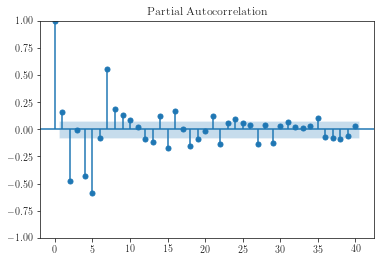

In [37]:
a = plot_pacf(training_pos['tweets_pos'], lags=40)

In [38]:
# creating models based on the number of lags shown by the criterias above

model_fit1 = model.fit(22, ic='aic')
model_fit2 = model.fit(9, ic='bic')
model_fit3 = model.fit(16, ic='hqic')

In [39]:
pred1 = model_fit1.forecast(training_pos.values[-22:], 10)
pred2 = model_fit2.forecast(training_pos.values[-9:], 10)
pred3 = model_fit3.forecast(training_pos.values[-16:], 10)

In [40]:
PRED1_LIST = [item[0] for item in pred1]
PRED2_LIST = [item[0] for item in pred2]
PRED3_LIST = [item[0] for item in pred3]

In [41]:
start_date = dt.datetime(2021,11,20)
end_date = dt.datetime(2021,11,30)
date_range = pd.date_range(start_date, end_date, freq='d')

In [42]:
pos_f = org_list[1]

In [43]:
pos_avg = avg_list[1]
pos_std = std_list[1]

In [44]:
pos_first = (632 - pos_avg) / pos_std
cases_first = 125588

In [45]:
PRED1_LIST_org = np.r_[pos_first, np.array(PRED1_LIST)].cumsum() * pos_std + pos_avg
PRED2_LIST_org = np.r_[pos_first, np.array(PRED2_LIST)].cumsum() * pos_std + pos_avg
PRED3_LIST_org = np.r_[pos_first, np.array(PRED3_LIST)].cumsum() * pos_std + pos_avg

In [46]:
df_pred_pos1 = pd.DataFrame(PRED1_LIST_org, index=date_range)
df_pred_pos2 = pd.DataFrame(PRED2_LIST_org, index=date_range)
df_pred_pos3 = pd.DataFrame(PRED3_LIST_org, index=date_range)

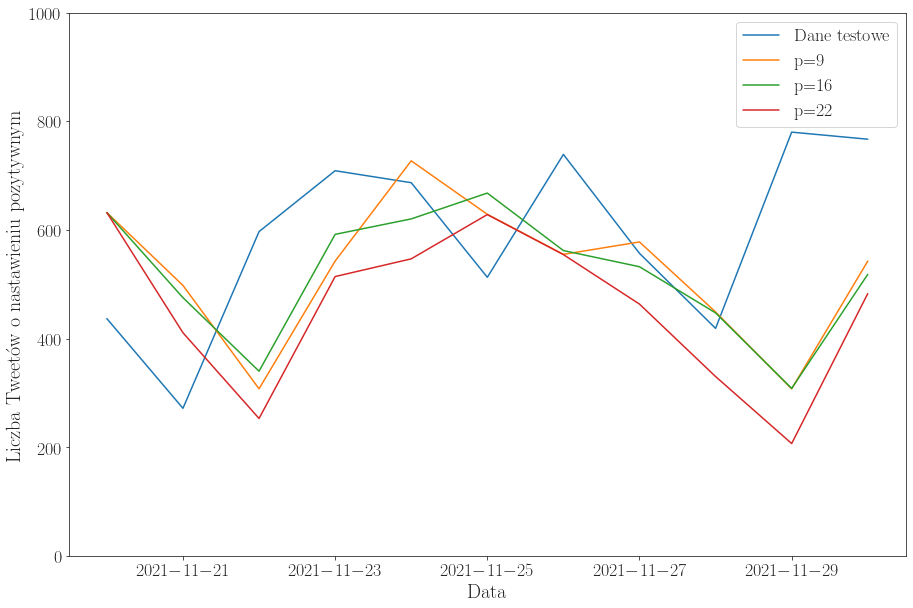

In [47]:
# plotting the predictions and testing data

plt.figure(figsize=(15,10))

ax = plt.gca()
ax.set_ylim([0, 1000])

ax.plot(df_test_org['tweets_pos'].loc[df_test_org.index > dt.datetime(2021, 11, 19)], label='Dane testowe')

ax.plot(date_range, df_pred_pos2[0], label='p=9')
ax.plot(date_range, df_pred_pos3[0], label='p=16')
ax.plot(date_range, df_pred_pos1[0], label='p=22')

plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel('Data', fontsize=20)
plt.ylabel('Liczba Tweetów o nastawieniu pozytywnym', fontsize=20)
plt.legend()
plt.legend(prop={"size":18})


from matplotlib import rc



rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)

plt.savefig('pos_predykcja.png', dpi=300)

In [48]:
# functions for calculating RMSE and MAPE

def RMSE(test, pred):
    return np.round(np.sqrt(((test-pred)**2).sum()/len(test)), 4)

def MAPE(test, pred):
    return np.round((np.abs((test - pred) / test).sum() / len(test) * 100), 4)

In [49]:
RMSE(df_test_org['tweets_pos'].loc[df_test_org.index > dt.datetime(2021, 11, 19)], df_pred_pos1[0])

253.2816

In [50]:
MAPE(df_test_org['tweets_pos'].loc[df_test_org.index > dt.datetime(2021, 11, 19)], df_pred_pos1[0])

36.0862

In [51]:
RMSE(df_test_org['tweets_pos'].loc[df_test_org.index > dt.datetime(2021, 11, 19)], df_pred_pos2[0])

218.2126

In [52]:
MAPE(df_test_org['tweets_pos'].loc[df_test_org.index > dt.datetime(2021, 11, 19)], df_pred_pos2[0])

32.1514

In [53]:
RMSE(df_test_org['tweets_pos'].loc[df_test_org.index > dt.datetime(2021, 11, 19)], df_pred_pos3[0])

214.0967

In [54]:
MAPE(df_test_org['tweets_pos'].loc[df_test_org.index > dt.datetime(2021, 11, 19)], df_pred_pos3[0])

31.5307

Below the Granger causality of time series is tested.

In [55]:
print(model_fit1.test_causality('tweets_pos', 'cases', kind='f'))

<statsmodels.tsa.vector_ar.hypothesis_test_results.CausalityTestResults object. H_0: cases does not Granger-cause tweets_pos: fail to reject at 5% significance level. Test statistic: 0.199, critical value: 1.551>, p-value: 1.000>


In [56]:
print(model_fit2.test_causality('tweets_pos', 'cases', kind='f'))

<statsmodels.tsa.vector_ar.hypothesis_test_results.CausalityTestResults object. H_0: cases does not Granger-cause tweets_pos: fail to reject at 5% significance level. Test statistic: 0.289, critical value: 1.887>, p-value: 0.978>


In [57]:
print(model_fit3.test_causality('tweets_pos', 'cases', kind='f'))

<statsmodels.tsa.vector_ar.hypothesis_test_results.CausalityTestResults object. H_0: cases does not Granger-cause tweets_pos: fail to reject at 5% significance level. Test statistic: 0.184, critical value: 1.652>, p-value: 1.000>


# VAR neutral

Now is the time for creating a model for Tweets with neutral sentiment.

In [58]:
training_neu = df_training[['tweets_neu', 'cases']]

In [59]:
model = VAR(training_neu, freq ='D')

In [60]:
for i in ['aic', 'bic', 'hqic']:
    
    results = model.fit(maxlags=40, ic=i)
    order = results.k_ar
    print(f"The suggested VAR order from {i} is {order}")

The suggested VAR order from aic is 13
The suggested VAR order from bic is 9
The suggested VAR order from hqic is 13


In [61]:
model_fit1 = model.fit(13, ic='aic')
model_fit2 = model.fit(9, ic='bic')

In [62]:
pred1 = model_fit1.forecast(training_neu.values[-13:], 10)
pred2 = model_fit2.forecast(training_neu.values[-9:], 10)

In [63]:
PRED1_LIST = [item[0] for item in pred1]
PRED2_LIST = [item[0] for item in pred2]

In [64]:
neu_avg = avg_list[2]
neu_std = std_list[2]
neu_f = org_list[2]

In [65]:
PRED1_LIST_org = np.r_[neu_f, np.array(PRED1_LIST)].cumsum() * neu_std + neu_avg
PRED2_LIST_org = np.r_[neu_f, np.array(PRED2_LIST)].cumsum() * neu_std + neu_avg

In [66]:
df_pred_neu1 = pd.DataFrame(PRED1_LIST_org, index=date_range)
df_pred_neu2 = pd.DataFrame(PRED2_LIST_org, index=date_range)

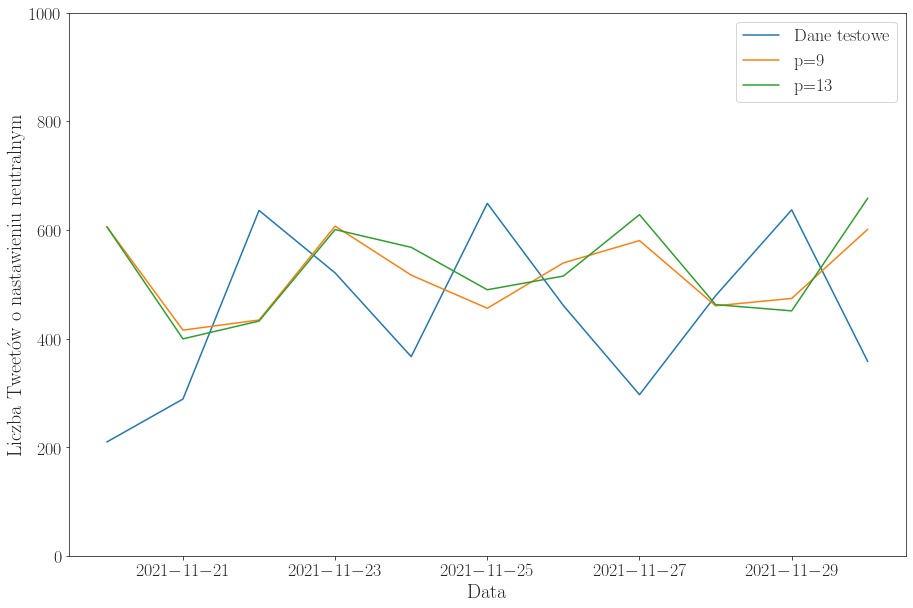

In [67]:
# plotting the predictions

plt.figure(figsize=(15,10))

ax = plt.gca()
ax.set_ylim([0, 1000])

ax.plot(df_test_org['tweets_neu'].loc[df_test_org.index > dt.datetime(2021, 11, 19)], label='Dane testowe')

ax.plot(date_range, df_pred_neu2[0], label='p=9')
ax.plot(date_range, df_pred_neu1[0], label='p=13')

plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel('Data', fontsize=20)
plt.ylabel('Liczba Tweetów o nastawieniu neutralnym', fontsize=20)
plt.legend()
plt.legend(prop={"size":18})

plt.savefig('neu_predykcja.png', dpi=300)

In [68]:
RMSE(df_test_org['tweets_neu'].loc[df_test_org.index > dt.datetime(2021, 11, 19)], df_pred_neu1[0])

217.4865

In [69]:
MAPE(df_test_org['tweets_neu'].loc[df_test_org.index > dt.datetime(2021, 11, 19)], df_pred_neu1[0])

53.9341

In [70]:
RMSE(df_test_org['tweets_neu'].loc[df_test_org.index > dt.datetime(2021, 11, 19)], df_pred_neu2[0])

203.0093

In [71]:
MAPE(df_test_org['tweets_neu'].loc[df_test_org.index > dt.datetime(2021, 11, 19)], df_pred_neu2[0])

51.014

In [72]:
print(model_fit2.test_causality('tweets_neu', 'cases', kind='f'))

<statsmodels.tsa.vector_ar.hypothesis_test_results.CausalityTestResults object. H_0: cases does not Granger-cause tweets_neu: fail to reject at 5% significance level. Test statistic: 0.374, critical value: 1.887>, p-value: 0.948>


# VAR negative

Aaaaaand negative sentiment.

In [73]:
training_neg = df_training[['tweets_neg', 'cases']]

In [74]:
model = VAR(training_neg, freq ='D')

In [75]:
for i in ['aic', 'bic', 'hqic']:
    #maxlags takes the number of lags we want to test
    #ic takes the information criterion metod based on which order would be suggested
    results = model.fit(maxlags=40, ic=i)
    order = results.k_ar
    print(f"The suggested VAR order from {i} is {order}")

The suggested VAR order from aic is 21
The suggested VAR order from bic is 9
The suggested VAR order from hqic is 14


In [76]:
model_fit1 = model.fit(21, ic='aic')
model_fit2 = model.fit(9, ic='bic')
model_fit3 = model.fit(14, ic='hqic')

In [77]:
pred1 = model_fit1.forecast(training_neg.values[-21:], 10)
pred2 = model_fit2.forecast(training_neg.values[-9:], 10)
pred3 = model_fit3.forecast(training_neg.values[-14:], 10)

In [78]:
PRED1_LIST = [item[0] for item in pred1]
PRED2_LIST = [item[0] for item in pred2]
PRED3_LIST = [item[0] for item in pred3]

In [79]:
neg_avg = avg_list[3]
neg_std = std_list[3]
neg_f = org_list[3]

In [80]:
PRED1_LIST_org = np.r_[neg_f, np.array(PRED1_LIST)].cumsum() * neg_std + neg_avg
PRED2_LIST_org = np.r_[neg_f, np.array(PRED2_LIST)].cumsum() * neg_std + neg_avg
PRED3_LIST_org = np.r_[neg_f, np.array(PRED3_LIST)].cumsum() * neg_std + neg_avg

In [81]:
df_pred_neg1 = pd.DataFrame(PRED1_LIST_org, index=date_range)
df_pred_neg2 = pd.DataFrame(PRED2_LIST_org, index=date_range)
df_pred_neg3 = pd.DataFrame(PRED3_LIST_org, index=date_range)

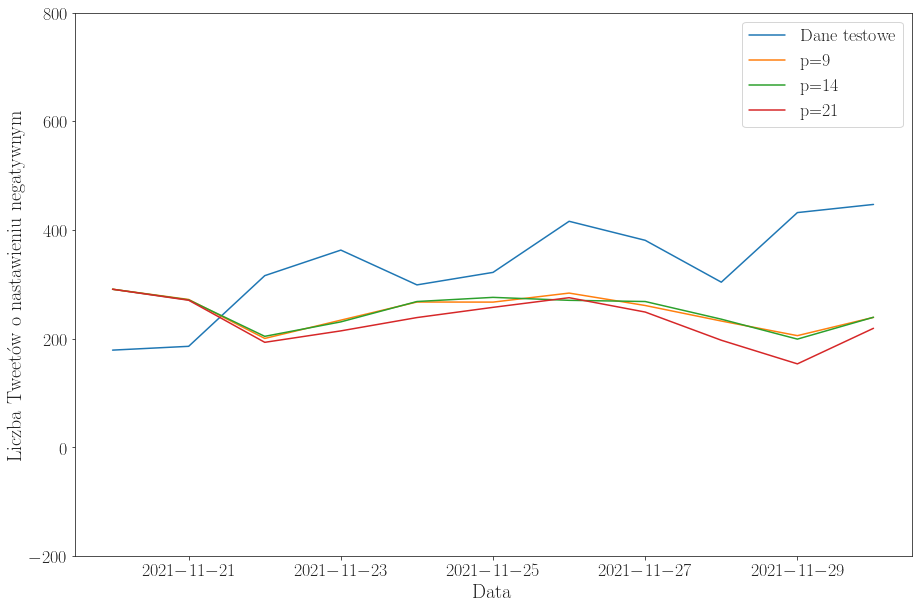

In [82]:
# plotting the predictions

plt.figure(figsize=(15,10))

ax = plt.gca()
ax.set_ylim([-200, 800])

ax.plot(df_test_org['tweets_neg'].loc[df_test_org.index > dt.datetime(2021, 11, 19)], label='Dane testowe')

ax.plot(date_range, df_pred_neg2[0], label='p=9')
ax.plot(date_range, df_pred_neg3[0], label='p=14')
ax.plot(date_range, df_pred_neg1[0], label='p=21')

plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel('Data', fontsize=20)
plt.ylabel('Liczba Tweetów o nastawieniu negatywnym', fontsize=20)
plt.legend()
plt.legend(prop={"size":18})

plt.savefig('neg_predykcja.png', dpi=300)

In [83]:
RMSE(df_test_org['tweets_neg'].loc[df_test_org.index > dt.datetime(2021, 11, 19)], df_pred_neg1[0])

148.4883

In [84]:
MAPE(df_test_org['tweets_neg'].loc[df_test_org.index > dt.datetime(2021, 11, 19)], df_pred_neg1[0])

40.6282

In [85]:
RMSE(df_test_org['tweets_neg'].loc[df_test_org.index > dt.datetime(2021, 11, 19)], df_pred_neg2[0])

129.7692

In [86]:
MAPE(df_test_org['tweets_neg'].loc[df_test_org.index > dt.datetime(2021, 11, 19)], df_pred_neg2[0])

35.8257

In [87]:
RMSE(df_test_org['tweets_neg'].loc[df_test_org.index > dt.datetime(2021, 11, 19)], df_pred_neg3[0])

130.8934

In [88]:
MAPE(df_test_org['tweets_neg'].loc[df_test_org.index > dt.datetime(2021, 11, 19)], df_pred_neg3[0])

35.6254

In [89]:
print(model_fit3.test_causality('tweets_neg', 'cases', kind='f'))

<statsmodels.tsa.vector_ar.hypothesis_test_results.CausalityTestResults object. H_0: cases does not Granger-cause tweets_neg: fail to reject at 5% significance level. Test statistic: 0.268, critical value: 1.728>, p-value: 0.995>


# VAR all

Finally a VAR for all the Tweets.

In [90]:
training_all = df_training[['tweets_all', 'cases']]

In [91]:
model = VAR(training_all, freq ='D')

In [92]:
for i in ['aic', 'bic', 'hqic']:
    #maxlags takes the number of lags we want to test
    #ic takes the information criterion metod based on which order would be suggested
    results = model.fit(maxlags=40, ic=i)
    order = results.k_ar
    print(f"The suggested VAR order from {i} is {order}")

The suggested VAR order from aic is 21
The suggested VAR order from bic is 9
The suggested VAR order from hqic is 14


In [93]:
model_fit1 = model.fit(21, ic='aic')
model_fit2 = model.fit(9, ic='bic')
model_fit3 = model.fit(14, ic='hqic')

In [94]:
pred1 = model_fit1.forecast(training_all.values[-21:], 10)
pred2 = model_fit2.forecast(training_all.values[-9:], 10)
pred3 = model_fit3.forecast(training_all.values[-14:], 10)

In [95]:
PRED1_LIST = [item[0] for item in pred1]
PRED2_LIST = [item[0] for item in pred2]
PRED3_LIST = [item[0] for item in pred3]

In [96]:
all_avg = avg_list[0]
all_std = std_list[0]
all_f = org_list[0]

In [97]:
PRED1_LIST_org = np.r_[all_f, np.array(PRED1_LIST)].cumsum() * all_std + all_avg
PRED2_LIST_org = np.r_[all_f, np.array(PRED2_LIST)].cumsum() * all_std + all_avg
PRED3_LIST_org = np.r_[all_f, np.array(PRED3_LIST)].cumsum() * all_std + all_avg

df_pred_all1 = pd.DataFrame(PRED1_LIST_org, index=date_range)
df_pred_all2 = pd.DataFrame(PRED2_LIST_org, index=date_range)
df_pred_all3 = pd.DataFrame(PRED3_LIST_org, index=date_range)

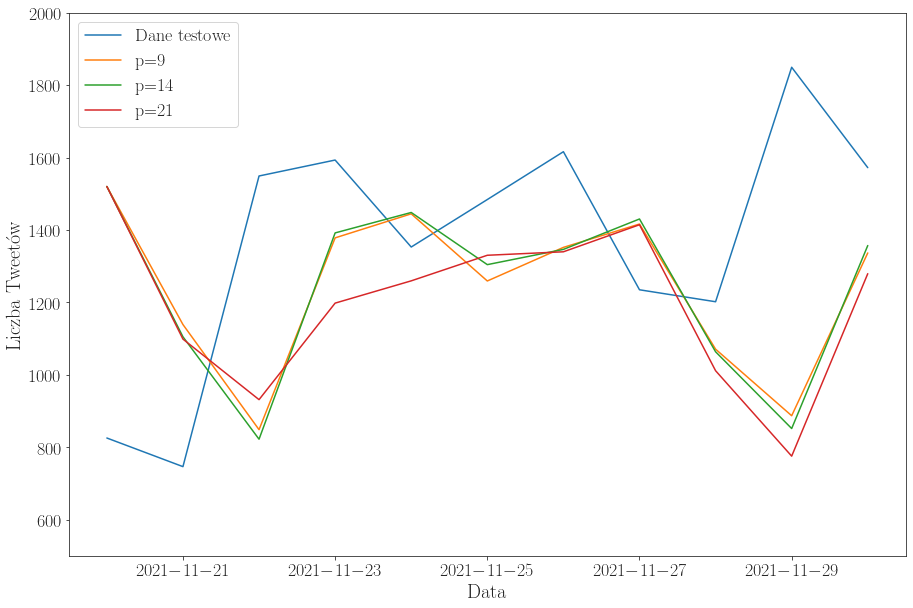

In [98]:
plt.figure(figsize=(15,10))

ax = plt.gca()
ax.set_ylim([500, 2000])

ax.plot(df_test_org['tweets_all'].loc[df_test_org.index > dt.datetime(2021, 11, 19)], label='Dane testowe')

ax.plot(date_range, df_pred_all2[0], label='p=9')
ax.plot(date_range, df_pred_all3[0], label='p=14')
ax.plot(date_range, df_pred_all1[0], label='p=21')

plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel('Data', fontsize=20)
plt.ylabel('Liczba Tweetów', fontsize=20)
plt.legend()
plt.legend(prop={"size":18})

plt.savefig('all_predykcja.png', dpi=300)

In [99]:
RMSE(df_test_org['tweets_all'].loc[df_test_org.index > dt.datetime(2021, 11, 19)], df_pred_all1[0])

482.0743

In [100]:
MAPE(df_test_org['tweets_all'].loc[df_test_org.index > dt.datetime(2021, 11, 19)], df_pred_all1[0])

30.6474

In [101]:
RMSE(df_test_org['tweets_all'].loc[df_test_org.index > dt.datetime(2021, 11, 19)], df_pred_all2[0])

460.2399

In [102]:
MAPE(df_test_org['tweets_all'].loc[df_test_org.index > dt.datetime(2021, 11, 19)], df_pred_all2[0])

29.6343

In [103]:
RMSE(df_test_org['tweets_all'].loc[df_test_org.index > dt.datetime(2021, 11, 19)], df_pred_all3[0])

466.0394

In [104]:
MAPE(df_test_org['tweets_all'].loc[df_test_org.index > dt.datetime(2021, 11, 19)], df_pred_all3[0])

29.2925

In [105]:
print(model_fit3.test_causality('tweets_all', 'cases', kind='f'))

<statsmodels.tsa.vector_ar.hypothesis_test_results.CausalityTestResults object. H_0: cases does not Granger-cause tweets_all: fail to reject at 5% significance level. Test statistic: 0.209, critical value: 1.728>, p-value: 0.999>
